# Interactive Recommendation System with Word Embeddings using Word2Vec, Plotly, and NetworkX

# 1) Dataset:


[This is the dataset](https://eightportions.com/datasets/Recipes/#fn:1) we will be using. It is collated by Ryan Lee, sourced from [Food Network](https://www.foodnetwork.com/), [Epicurious](https://www.epicurious.com/), and [Allrecipes](https://www.allrecipes.com/).

In [2]:
from gensim.parsing.preprocessing import remove_stopwords
from tqdm import tqdm
import pandas as pd
import pickle
import string
import json

In [3]:
recipe_sources = ['ar', 'epi', 'fn']

In [4]:
temp = json.load(open('Data/Dataset/recipes_raw_nosource_ar.json'))

In [5]:
df = pd.DataFrame()
sources, titles, ingredients, instructions = [], [], [], []
for recipe_source in recipe_sources:
    data = json.load(open(f'Data/Dataset/recipes_raw_nosource_{recipe_source}.json', 'r'))
    for _, recipe in data.items():
        if ('title' in recipe) and ('ingredients' in recipe) and ('instructions' in recipe):
            # append to a list of the source
            sources.append(recipe_source)
            # append to a list of the titles
            titles.append(recipe['title'])
            # append to a list of a list of ingredients, removing the word ADVERTISEMENT
            ingredients.append([str(ingredient).replace('ADVERTISEMENT', '') for ingredient in recipe['ingredients']])
            # append to a list of instructions, removing the word ADVERTISEMENT and replace \n with space characters
            instructions.append(str(recipe['instructions']).replace('ADVERTISEMENT', '').replace('\n', ' '))
df['source'] = sources
df['title'] = titles
df['ingredients'] = ingredients
df['instructions'] = instructions

In [6]:
df.head()

,source,title,ingredients,instructions
0,ar,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves , ...","Place the chicken, butter, soup, and onion in ..."
1,ar,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,ar,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar , 1/2 cup ketchup ...",Preheat oven to 350 degrees F (175 degrees C)....
3,ar,Best Chocolate Chip Cookies,"[1 cup butter, softened , 1 cup white sugar , ...",Preheat oven to 350 degrees F (175 degrees C)....
4,ar,Homemade Mac and Cheese Casserole,"[8 ounces whole wheat rotini pasta , 3 cups fr...",Preheat oven to 350 degrees F. Line a 2-quart ...


# 2) Exploratory Data Analysis and Preprocessing

In [7]:
to_remove = [
    'tablespoon',
    'tablespoons',
    'teaspoon',
    'teaspoons',
    'tsp',
    'tsps',
    'tbsp',
    'tbsps',
    'pound',
    'pounds',
    'grams',
    'mg',
    'ounce'
    'ounces',
    'kg',
    'crushed',
    'chopped',
    'finely',
    'softened',
    'cups',
    'cup'
]

translation_table = str.maketrans('', '', string.punctuation+string.digits)

In [8]:
def preprocess(items):
    res = []
    for i, item in enumerate(items):
        temp = item.lower().replace('-', ' ')
        temp = temp.translate(translation_table)
        temp = remove_stopwords(temp)
        for stop_word in to_remove:
            temp = temp.replace(stop_word, '')
        res.append(temp.split())
    return res

In [9]:
instructions = df.instructions.values.tolist()
ingredients = [', '.join(x) for x in df.ingredients.values.tolist()]

In [10]:
train_data = preprocess(instructions+ingredients)

In [11]:
with open('Data/train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

# 3) Word2Vec with Gensim

In [12]:
from gensim.models.word2vec import Word2Vec

In [13]:
with open('Data/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [14]:
model = Word2Vec()

In [15]:
model.build_vocab(train_data)

In [16]:
%%time
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 38.1 s


(68100653, 81403200)

In [17]:
res = model.wv.most_similar('lemon chicken garlic onion'.split(), topn=20)
res

[('shallot', 0.6532975435256958),
 ('shallots', 0.6109850406646729),
 ('onions', 0.5517314672470093),
 ('scallions', 0.49954402446746826),
 ('curry', 0.49764353036880493),
 ('oregano', 0.4934392273426056),
 ('cumin', 0.491748183965683),
 ('pepper', 0.48461732268333435),
 ('tomato', 0.47119635343551636),
 ('tomatoes', 0.46444055438041687),
 ('leek', 0.4641241133213043),
 ('carrot', 0.4622250199317932),
 ('chile', 0.45560967922210693),
 ('carrots', 0.45525264739990234),
 ('turmeric', 0.45009851455688477),
 ('lime', 0.4498577415943146),
 ('parsley', 0.4495808780193329),
 ('chili', 0.4459580183029175),
 ('paprika', 0.43867456912994385),
 ('thyme', 0.4369201362133026)]

In [18]:
model.save('Data/w2v.model')

# 4) Exploring Results

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#matplotlib.rcParams['figure.dpi'] = 800
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
random.seed(3)

In [20]:
model = Word2Vec.load('Data/w2v.model')

In [21]:
inferred_vector = model.wv.most_similar('lemon chicken garlic onion'.split(), topn=20)
inferred_vector

[('shallot', 0.6532975435256958),
 ('shallots', 0.6109850406646729),
 ('onions', 0.5517314672470093),
 ('scallions', 0.49954402446746826),
 ('curry', 0.49764353036880493),
 ('oregano', 0.4934392273426056),
 ('cumin', 0.491748183965683),
 ('pepper', 0.48461732268333435),
 ('tomato', 0.47119635343551636),
 ('tomatoes', 0.46444055438041687),
 ('leek', 0.4641241133213043),
 ('carrot', 0.4622250199317932),
 ('chile', 0.45560967922210693),
 ('carrots', 0.45525264739990234),
 ('turmeric', 0.45009851455688477),
 ('lime', 0.4498577415943146),
 ('parsley', 0.4495808780193329),
 ('chili', 0.4459580183029175),
 ('paprika', 0.43867456912994385),
 ('thyme', 0.4369201362133026)]

In [22]:
with open('Data/items_for_sale.txt') as f:
    items_for_sale = f.read().split('\n')

In [23]:
words, vectors = [], []
for item in items_for_sale:
    try:
        words.append(item)
        vectors.append(model.wv.get_vector(item))
    except KeyError:
        print(f'Word {item} not found in model!')

Word jalapeÃ±o not found in model!
Word crÃ¨me not found in model!
Word gruyÃ¨re not found in model!
Word tabascoÂ® not found in model!
Word jalapeÃ±os not found in model!
Word krispiesÂ® not found in model!
Word knorrÂ® not found in model!
Word kelloggsÂ® not found in model!
Word splendaÂ® not found in model!
Word nestleÂ® not found in model!
Word truviaÂ® not found in model!
Word pimentÃ³n not found in model!
Word hersheysÂ® not found in model!
Word kahluaÂ® not found in model!
Word kahlÃºa not found in model!
Word spamÂ® not found in model!
Word oreoÂ® not found in model!
Word bisquickÂ® not found in model!
Word heinzÂ® not found in model!
Word nutellaÂ® not found in model!
Word nestlÃ©Â® not found in model!
Word orÃ©gano not found in model!
Word monteÂ® not found in model!
Word hellmannsÂ® not found in model!
Word frescoÂ® not found in model!
Word soufflÃ© not found in model!
Word liptonÂ® not found in model!
Word butterfingerÂ® not found in model!
Word rosÃ© not found in model!
Wo

In [24]:
sims = cosine_similarity(vectors, vectors)

In [25]:
for i in range(len(vectors)):
    for j in range(len(vectors)):
        if i<=j:
            sims[i, j] = False

In [26]:
k = 20
indices = list(range(len(vectors)))
random.shuffle(indices)
indices = indices[:k]

small_vectors = [vectors[i] for i in indices]
small_words = [words[i] for i in indices]

small_sims = cosine_similarity(small_vectors, small_vectors)

for x in range(len(small_sims)):
    small_sims[x, x] = 0

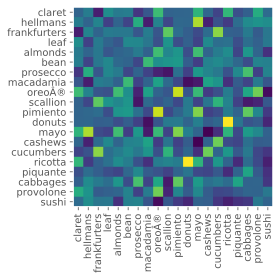

In [27]:
# adapted from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
im = ax.imshow(small_sims)

ax.set_xticks(np.arange(len(small_vectors)))
ax.set_yticks(np.arange(len(small_vectors)))

ax.set_xticklabels(small_words)
ax.set_yticklabels(small_words)
ax.grid(False)

plt.setp(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
plt.savefig('plot2.png', dpi=300)
plt.show()

In [28]:
np.savetxt('Data/words.txt', words, fmt='%s')
np.save('Data/vectors.npy', vectors)

# 5) Building and Visualizing Interactive Network Graph
Let's see if we can visualize our results better!

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
from plotly.offline import plot
import networkx as nx
import numpy as np

In [30]:
words = np.loadtxt('Data/words.txt', dtype=str)
vectors = np.load('Data/vectors.npy')

In [31]:
sims = cosine_similarity(vectors, vectors)

In [32]:
for i in range(len(vectors)):
    for j in range(len(vectors)):
        if i<=j:
            sims[i, j] = False

In [33]:
indices = np.argwhere(sims > 0.65)

In [34]:
indices[0]

array([18, 16], dtype=int64)

In [35]:
G = nx.Graph()

for index in indices:
    G.add_edge(words[index[0]], words[index[1]], weight=sims[index[0], index[1]])

In [36]:
weight_values = nx.get_edge_attributes(G, 'weight')
weight_values[('egg', 'eggs')]

0.77217

In [37]:
positions = nx.spring_layout(G)

In [38]:
nx.set_node_attributes(G, name='position', values=positions)

In [39]:
searches = []

In [40]:
edge_x = []
edge_y = []
weights = []
ave_x, ave_y = [], []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['position']
    x1, y1 = G.nodes[edge[1]]['position']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    ave_x.append(np.mean([x0, x1]))
    ave_y.append(np.mean([y0, y1]))
    weights.append(f'{edge[0]}, {edge[1]}: {weight_values[(edge[0], edge[1])]}')

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    opacity=0.7,
    line=dict(width=2, color='White'),
    hoverinfo='text',
    mode='lines')

edge_trace.text = weights


node_x = []
node_y = []
sizes = []
for node in G.nodes():
    x, y = G.nodes[node]['position']
    node_x.append(x)
    node_y.append(y)
    if node in searches:
        sizes.append(50)
    else:
        sizes.append(15)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        line=dict(color='White'),
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Picnic',
        reversescale=False,
        color=[],
        opacity=0.9,
        size=sizes,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    )
)

invisible_similarity_trace = go.Scatter(
    x=ave_x, y=ave_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        opacity=0,
    )
)

invisible_similarity_trace.text=weights

In [41]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(adjacencies[0])

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [42]:
fig = go.Figure(
    data=[edge_trace, node_trace, invisible_similarity_trace],
    layout=go.Layout(
        title='Network Graph of Word Embeddings',
        template='plotly_dark',
        titlefont_size=20,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[
            dict(
                text="Adapted from: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002 ) 
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

plot(fig)

'temp-plot.html'